In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [2]:
def show_results(*args):
    
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = args
    
    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0], 'r-', label='minimum') # min
    plt.plot(history_objective_values[:, 1], 'g-', label='maximum') # max
    plt.plot(history_objective_values[:, 2], 'b-', label='mean') # mean
    plt.xlabel('iteration')
    plt.ylabel('objective function value')
    plt.title('min/avg/max objective function values')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas, 'r-')
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()

In [3]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring,
       number_of_parents, sigma, tau, tau_0, log_frequency=1, min_domain=-100, max_domain=100, mutation_type='no_correl',
      log_function=None):
 
    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 9999999.0

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))
    
    # generating an initial population
    current_population_solutions = np.random.uniform(min_domain, max_domain, size=(population_size, chromosome_length))
    
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))
    current_population_mats = sigma * np.ones((population_size, chromosome_length, chromosome_length))
    
    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):
        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values.max() - current_population_objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.empty((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
          
        
        # mutation
        if mutation_type=='no_correl':
            children_population_sigmas = np.empty((number_of_offspring, chromosome_length))
            for i in range(number_of_offspring):
                children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)
            
            children_population_sigmas = children_population_sigmas * np.exp(tau * \
                np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
            
            for i in range(number_of_offspring):
                children_population_solutions[i, :] = children_population_solutions[i, :] + children_population_sigmas[i,:] * np.random.randn(1, chromosome_length)
                
        elif mutation_type=='correl':
            children_population_mats = np.empty((number_of_offspring, chromosome_length, chromosome_length))
            for i in range(number_of_offspring):
                children_population_mats[i,:,:] = current_population_mats[parent_indices[i, :],:,:].mean(axis=0)
            
            children_population_mats = children_population_mats * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length, chromosome_length) \
                                                                         + tau_0 * np.random.randn(number_of_offspring, 1, 1))
            
            for i in range(number_of_offspring):
                A = children_population_mats[i]
                covariance_mat = np.dot(A, A.T)
                children_population_solutions[i, :] = children_population_solutions[i, :] + np.dot(np.random.randn(1, chromosome_length), np.linalg.cholesky(covariance_mat).T)
         
        # clip to domains
        children_population_solutions[children_population_solutions < min_domain] = min_domain
        children_population_solutions[children_population_solutions > max_domain] = max_domain
            
        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)
        
        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        if mutation_type=='no_correl':
            current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])
        elif mutation_type=='correl':
            current_population_mats = np.vstack([current_population_mats, children_population_mats])
        
        I = np.argsort(current_population_objective_values)#[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]
        
        if mutation_type=='no_correl':
            current_population_sigmas = current_population_sigmas[I[:population_size], :]
        elif mutation_type=='correl':
            current_population_mats = current_population_mats[I[:population_size]]
    
    
        # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].min(), log_objective_values[t, 2]))
            if log_function: log_function(best_solution)
            
    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

In [11]:
def get_arms_coords(B, angles, lengths):
    N = angles.shape[0] # population size
    d = angles.shape[1] # chromosome length
    angles_sin = lengths * np.sin(angles*np.pi/180.0)
    angles_cos = lengths * np.cos(angles*np.pi/180.0)
    
    coords = np.zeros((N, d+1, 2))
    coords[:,0,:] = np.array(B)
    
    prev_vector = np.array([[-1.0,0.0] for _ in range(N)])
    prev_vector_perp = np.array([[0.0, 1.0] for _ in range(N)])
    for i in range(d):
        coords[:,i+1,:] = coords[:,i,:] - prev_vector*angles_cos[:,i][:,None] + prev_vector_perp*angles_sin[:,i][:,None]
        prev_vector = (coords[:,i+1,:]-coords[:,i,:])/lengths[i]
        prev_vector_perp = prev_vector[:, np.array([1,0])]
        prev_vector_perp[:,1] = -prev_vector_perp[:,1]
        
    return coords
    

def draw_inverse_kinematics(B, angles, lengths, target):
    N = lengths.shape[0]
    
    #target
    target_x, target_y = target[0], target[1]
    plt.scatter(np.array([target_x]), np.array([target_y]), s=200, marker='*', c="g")
    
    #arms
    coords = get_arms_coords(B, angles, lengths)[0]
    plt.plot(coords[:,0], coords[:,1], '-o', ms=10, lw=1.6, alpha=0.7, mfc='orange')
    plt.show()


In [28]:
def objective_1(X):
    target = np.array([10.0, 10.0])
    lengths = np.ones_like(X[0,:])
    coords = get_arms_coords((0,0), X, lengths)
    coords = np.linalg.norm(coords[:, -1, :] - target, axis=1)
    
    return coords

def objective_1_log_function(solution):
    target = np.array([10.0, 10.0])
    lengths = np.ones_like(solution)
    draw_inverse_kinematics((0,0), solution[None], lengths, target)

def objective_2(X, lengths, target, constraints=None):
    if np.any(constraints != None):
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[i,j] < constraints[j,0]:
                    X[i,j] = constraints[j,0]
                elif X[i,j] > constraints[j,1]:
                    X[i,j] = constraints[j,1]
    coords = get_arms_coords((0,0), X, lengths)
    coords = np.linalg.norm(coords[:, -1, :] - target, axis=1)
    
    return coords

def objective_2_log_function(solution, starting_point, lengths, target):
    draw_inverse_kinematics(starting_point, solution[None], lengths, target)

(15, 100, 5)
objective_1
Iteration 0000 : best score = 13.29923111, mean score = 11.23621859.


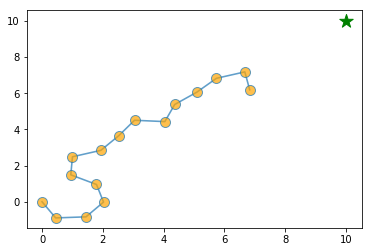

Iteration 0001 : best score = 10.93477895, mean score = 8.17726480.


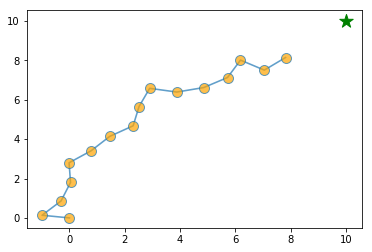

Iteration 0002 : best score = 6.53611908, mean score = 4.45392453.


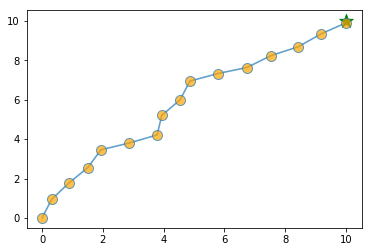

Iteration 0003 : best score = 2.47188798, mean score = 1.65599063.


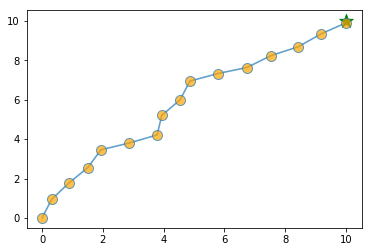

Iteration 0004 : best score = 0.78881121, mean score = 0.52270840.


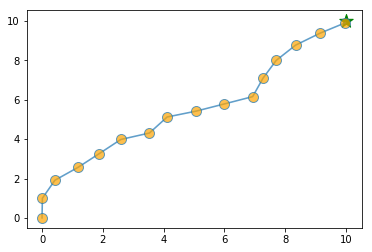

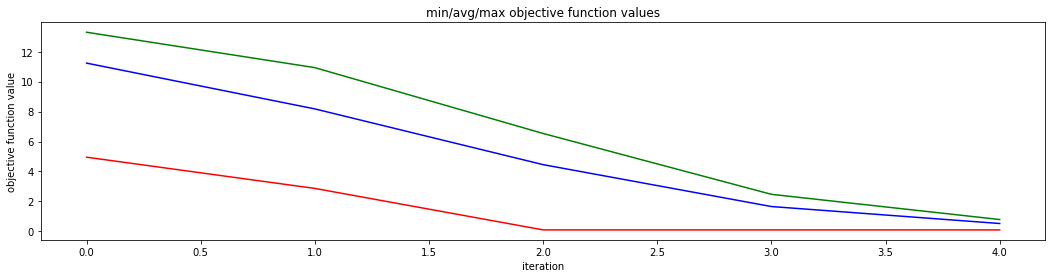

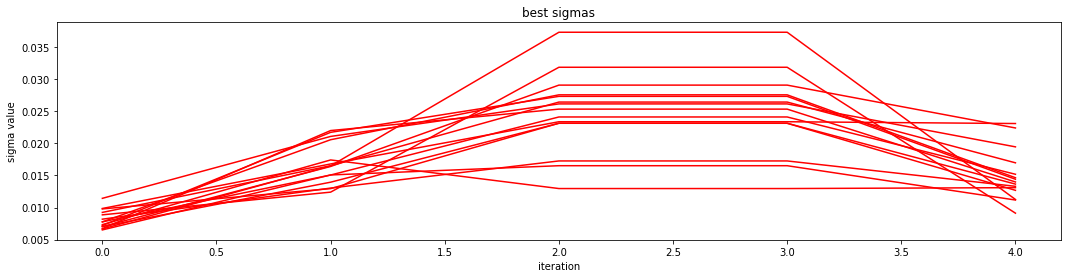

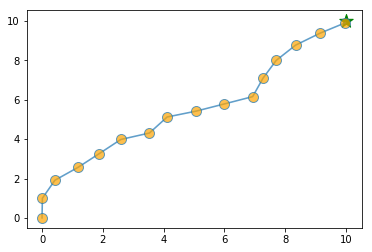

In [10]:
#(dim, ppl_size, iter, )
parameters = [
    (15, 100, 5),
]
for objective_function in [objective_1]:
    for d, N, T in parameters:
        print((d, N, T))
        print(objective_function.__name__)
        
        best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
            objective_function, d, N, number_of_iterations=T, number_of_offspring=2*N, number_of_parents=2,
            sigma=0.01, tau=1/np.sqrt(2*d), tau_0=1/np.sqrt(2*np.sqrt(d)), log_frequency=1, min_domain=0.0, 
            max_domain=360, mutation_type='no_correl', log_function=objective_1_log_function)

        show_results(best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas)
        draw_inverse_kinematics((0,0), best_chromosome[None,:], np.ones_like(best_chromosome), np.array([10.0, 10.0]))

(30, 400, 40)
objective_1
Iteration 0000 : best score = 12.91256417, mean score = 9.83374240.


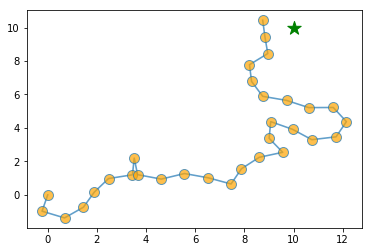

Iteration 0005 : best score = 3.71713895, mean score = 2.32387886.


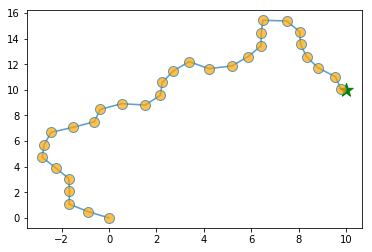

Iteration 0010 : best score = 0.42534423, mean score = 0.28307837.


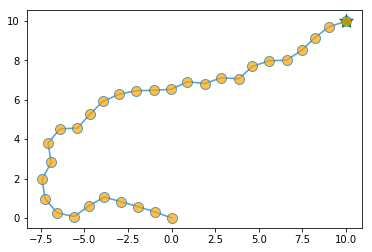

Iteration 0015 : best score = 0.01114391, mean score = 0.00713048.


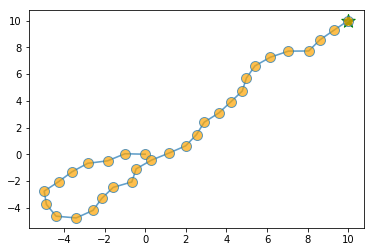

Iteration 0020 : best score = 0.00283488, mean score = 0.00174959.


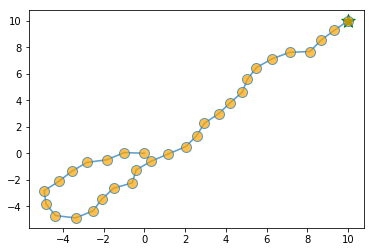

Iteration 0025 : best score = 0.00150764, mean score = 0.00096620.


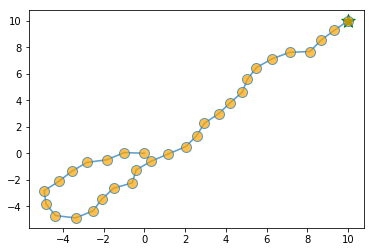

Iteration 0030 : best score = 0.00095570, mean score = 0.00062270.


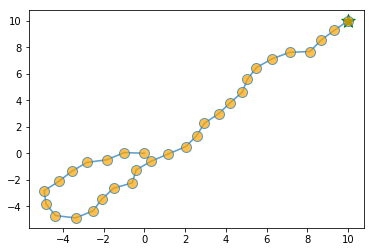

Iteration 0035 : best score = 0.00066576, mean score = 0.00043489.


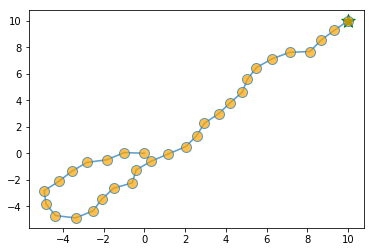

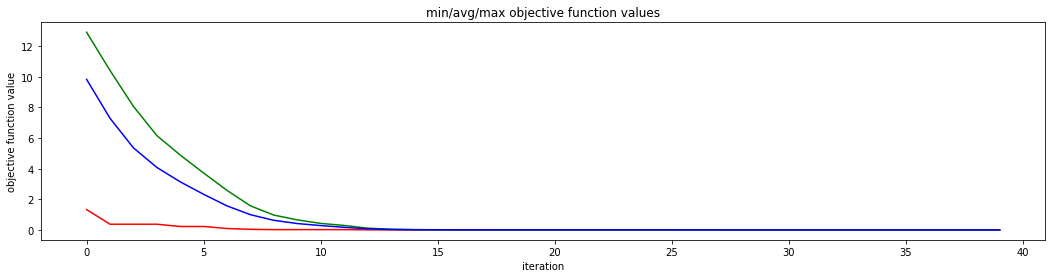

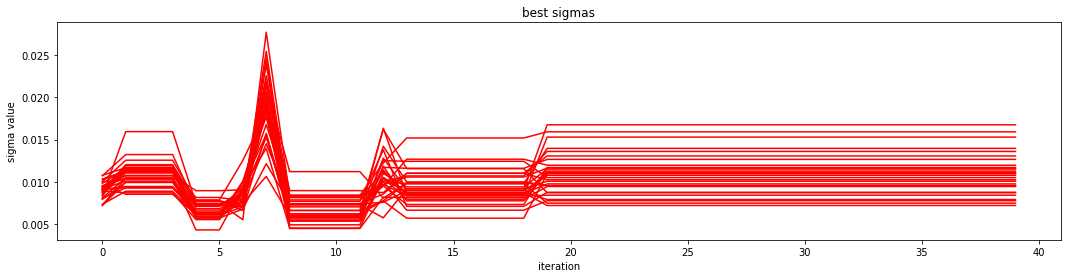

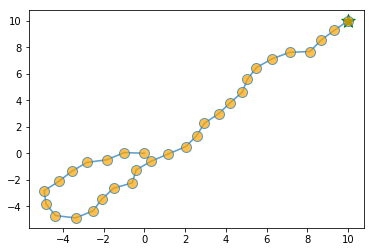

In [12]:
# params = (dim, ppl_size, iter)
parameters = [
    (30, 400, 40),
]
for objective_function in [objective_1]:
    for d, N, T in parameters:
        print((d, N, T))
        print(objective_function.__name__)
        
        best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
            objective_function, d, N, number_of_iterations=T, number_of_offspring=2*N, number_of_parents=2,
            sigma=0.01, tau=1/np.sqrt(2*d), tau_0=1/np.sqrt(2*np.sqrt(d)), log_frequency=5, min_domain=0.0, 
            max_domain=360, mutation_type='no_correl', log_function=objective_1_log_function)

        show_results(best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas)
        draw_inverse_kinematics((0,0), best_chromosome[None,:], np.ones_like(best_chromosome), np.array([10.0, 10.0]))

(30, 400, 60)
objective_2
Iteration 0000 : best score = 1300.79997734, mean score = 1054.89633059.


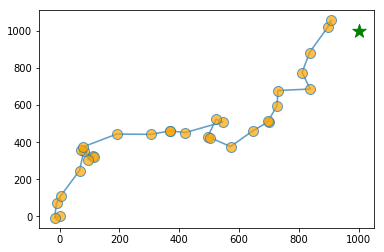

Iteration 0010 : best score = 69.53094197, mean score = 52.39979707.


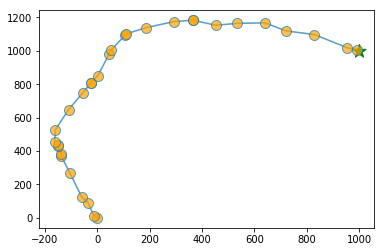

Iteration 0020 : best score = 0.98870835, mean score = 0.66242079.


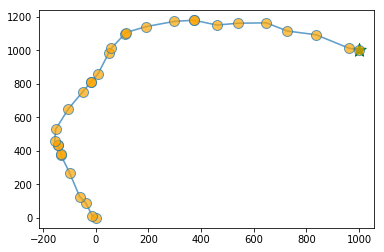

Iteration 0030 : best score = 0.17724880, mean score = 0.11267146.


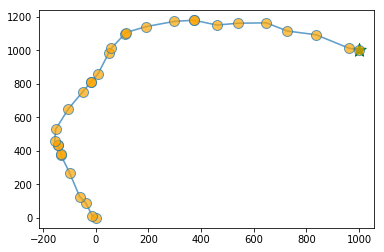

Iteration 0040 : best score = 0.08013283, mean score = 0.05435061.


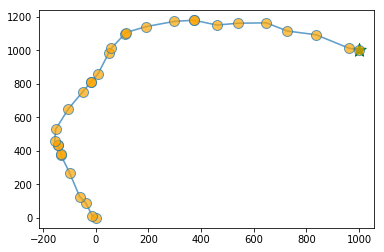

Iteration 0050 : best score = 0.04337351, mean score = 0.02932683.


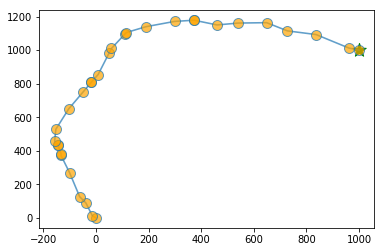

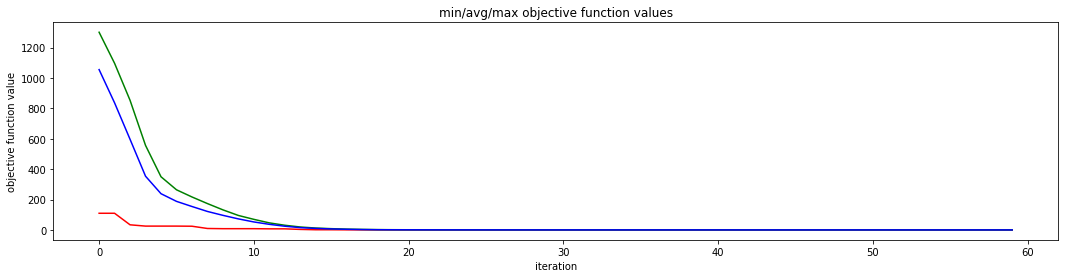

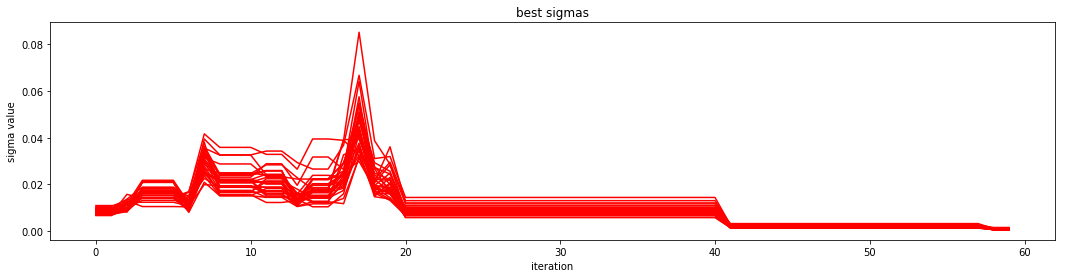

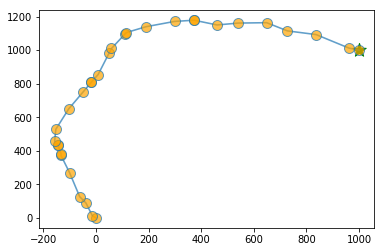

In [29]:
#(dim, ppl_size, iter, )
parameters = [
    (30, 400, 60),
]
target = np.array([1000.0, 1000.0])
for objective_function in [objective_2]:
    for d, N, T in parameters:
        print((d, N, T))
        print(objective_function.__name__)
        
        lengths = 150*np.random.rand(d)
        
        decorated_obj_fun = lambda X: objective_function(X, lengths, target)
        decorated_obj_log_fun = lambda X: objective_2_log_function(X, (0,0), lengths, target)
        
        best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
            decorated_obj_fun, d, N, number_of_iterations=T, number_of_offspring=2*N, number_of_parents=2,
            sigma=0.01, tau=1/np.sqrt(2*d), tau_0=1/np.sqrt(2*np.sqrt(d)), log_frequency=10, min_domain=0.0, 
            max_domain=360, mutation_type='no_correl', log_function=decorated_obj_log_fun)

        show_results(best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas)
        draw_inverse_kinematics((0,0), best_chromosome[None,:], lengths, target)

(30, 400, 100)
objective_2
Iteration 0000 : best score = 130.75164268, mean score = 96.18694806.


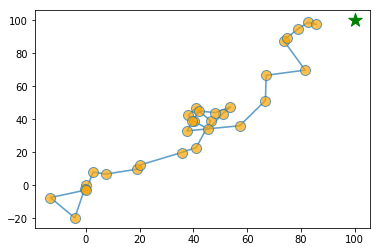

Iteration 0040 : best score = 0.00370726, mean score = 0.00241188.


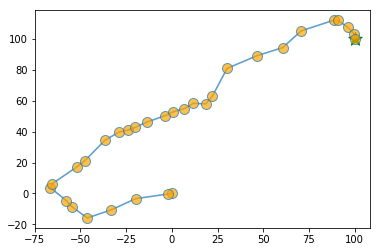

Iteration 0080 : best score = 0.00093711, mean score = 0.00061056.


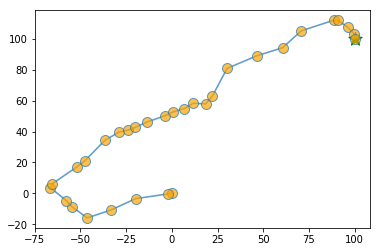

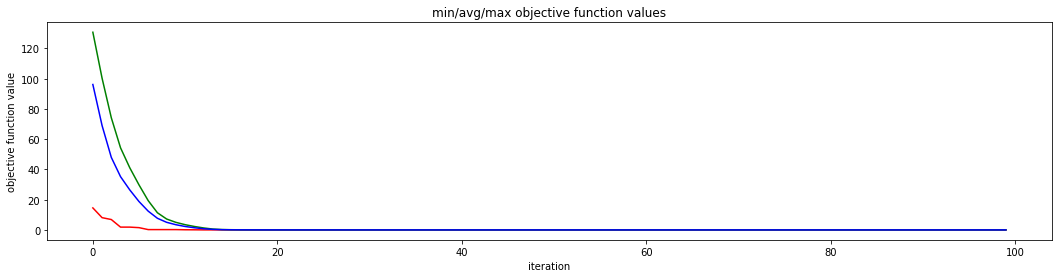

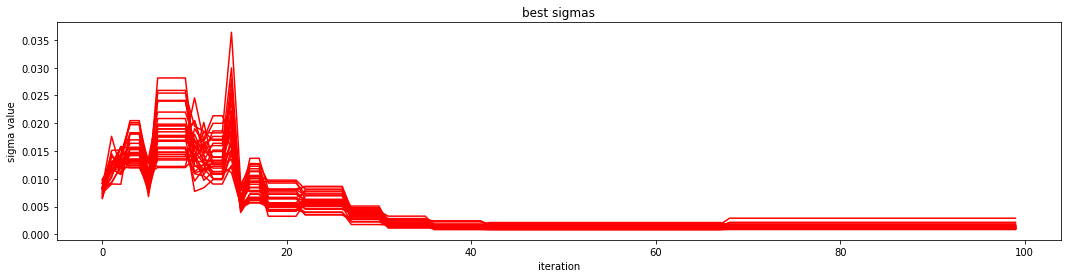

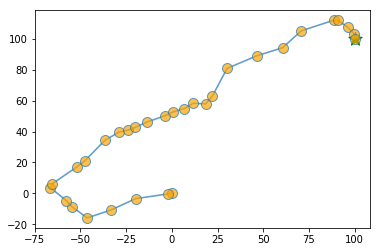

In [31]:
# Inverse Kinematics with angle constraints

#(dim, ppl_size, iter, )
parameters = [
    (30, 400, 100),
]
target = np.array([100.0, 100.0])

for objective_function in [objective_2]:
    for d, N, T in parameters:
        print((d, N, T))
        print(objective_function.__name__)
        
        lengths = 20*np.random.rand(d)
        constraints = 270*np.random.rand(d,2)
        constraints[:,1] = constraints[:,0] + 45
        constraints[constraints>360] = 360
        
        decorated_obj_fun = lambda X: objective_function(X, lengths, target)
        decorated_obj_log_fun = lambda X: objective_2_log_function(X, (0,0), lengths, target)
        
        best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
            decorated_obj_fun, d, N, number_of_iterations=T, number_of_offspring=2*N, number_of_parents=2,
            sigma=0.01, tau=1/np.sqrt(2*d), tau_0=1/np.sqrt(2*np.sqrt(d)), log_frequency=40, min_domain=0.0, 
            max_domain=360, mutation_type='no_correl', log_function=decorated_obj_log_fun)

        show_results(best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas)
        draw_inverse_kinematics((0,0), best_chromosome[None,:], lengths, target)